# Inference Notebook for 3D models

## Importing all necessary classes and functions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

sys.path.insert(0, "../../src")

import h5py
import torch
import zarr as z
import numpy as np

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.dl.checkpoint.manager import CheckpointManager
from juart.dl.model.unrollnet import ExponentialMovingAverageModel, UnrolledNet
from juart.dl.operation.modules import inference
from juart.dl.model.resnet import ResNet
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint, fourier_transform_forward, fourier_transform_adjoint
from juart.vis.interactive import InteractiveFigure3D

In [2]:
# To improve performance, manually limit the number of threads
# torch.set_num_threads(16)
# torch.set_num_interop_threads(16)

## Defining all important variables for the inference

In [3]:
# dataset options
kspace_cutoff = False
nX_cutoff, nY_cutoff, nZ_cutoff = 64, 64, 64 

# device options
device = "cuda:2" # device on which the reconstructions will run

# CheckpointManager options
directory = "nummodel0.0i_2P_2DC_2E_R1" # directory of the dl-qrage model
root_dir = "/home/jovyan/models" # the path to the model directory
backend = "local" # the backend of the model directory

# model options
shape = (128,128,128,1,1) # number of pixels in every direction // number of measurements at T1/T2 decay
nX, nY, nZ, nTI, nTE = shape # ordered structure of the parameters above that will be passed to the model
features = 32 # number of hidden_inputs of the dl-qrage model
cg_iter = 50 # number of cg iterations in the dl-qrage model reconstruction

# display options
vmax = 2 # sets the brightness normalization of the display between 0 and vmax
iTI, iTE = 1, 0 # sets the number of measurement that should be displayed

dtype = torch.complex64

## Loading the dataset that should be reconstructed
#### Loading Data

In [4]:
store = z.open("/home/jovyan/datasets/num_phantom_128_R1")

C = torch.from_numpy(np.array(store["C"]))
k = torch.from_numpy(np.array(store["k"]))[...,None,None]
d = torch.from_numpy(np.array(store["d"]))[...,None,None]

#### Shaping data

In [5]:
if kspace_cutoff == True:
    nX, nY ,nZ = nX_cutoff, nY_cutoff, nZ_cutoff
    shape = (nX, nY, nZ, nTI, nTE)
    
    mask = torch.linalg.norm(ktraj,dim=0) <= nX_cutoff//2
    
    ktraj = torch.stack(
        [ktraj[:, mask[:, echo], echo] for echo in range(ktraj.shape[2])],
        dim=-1
    )
    
    d = torch.stack(
        [d[:, mask[:, echo], echo] for echo in range(d.shape[2])],
        dim=-1
    )

    coilsens_ksp = fourier_transform_forward(coilsens, axes=(1,2,3))
    low_lim, up_lim = int(156/2 - nX/2), int(156/2 + nX/2)
    coilsens_ksp = coilsens_ksp[:, low_lim:up_lim, low_lim:up_lim, low_lim:up_lim]
    coilsens = fourier_transform_adjoint(coilsens_ksp, axes=(1,2,3))

In [6]:
kspace_mask_source = torch.randint(0,2,(1, k.shape[1], 1,1))
kspace_mask_target = 1 - kspace_mask_source

k_scaled = k / (2 * k.max())

AHd = nonuniform_fourier_transform_adjoint(k_scaled,d,(nX,nY,nZ))
AHd = torch.sum(torch.conj(C[...,None,None]) * AHd, dim=0)

In [7]:
data = {
    "images_regridded": AHd,
    "kspace_trajectory": k,
    "sensitivity_maps": C,
    "kspace_mask_source": kspace_mask_source,
    "kspace_mask_target": kspace_mask_target,
    "kspace_data": d,
}

## Checkpoint Manager
#### Initializing the CheckpointManager and loading the current state

In [8]:
checkpoint_manager = CheckpointManager(
    directory=directory,
    root_dir=root_dir,
    backend=backend,
)

checkpoint = checkpoint_manager.load(
    ["averaged_model_state", "iteration"], map_location="cuda:3"
)

## Model
#### Initializing the model and using the CheckpointManager to check for save files of the model and load them.

In [9]:
model = UnrolledNet(
    shape,
    features=features,
    CG_Iter=cg_iter,
    num_unroll_blocks=10,
    activation="ReLU",
    kernel_size = (3,3,3),
    axes = (1,2,3),
    disable_progress_bar=False,
    ResNetCheckpoints = True,
    ConvLayerCheckpoints = False,
    device=device,
    dtype = dtype
)

model = ExponentialMovingAverageModel(model, 0.9)
# model.load_state_dict(checkpoint["averaged_model_state"])

iteration = checkpoint["iteration"]
print(f"Loaded averaged at iteration {iteration}.")

Loaded averaged at iteration 4.


## Image reconstruction

In [10]:
images = inference(data, model, device=device)

100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


### Displaying the reconstructed image in an interactive Figure

interactive(children=(IntSlider(value=64, description='Dimension 3', max=128, min=1), Output()), _dom_classes=…

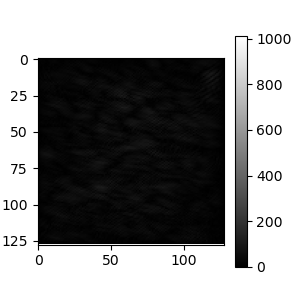

In [11]:
InteractiveFigure3D(
    torch.abs(images[...,0,0]).cpu().numpy(),
    vmin=0,
    vmax=torch.abs(images[...,0,0]).cpu().max(),
    cmap="gray",
).interactive